# Report04 - Nathan Yee

This notebook contains report04 for computational baysian statistics fall 2016

MIT License: https://opensource.org/licenses/MIT

In [2]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalPdf, MakeNormalPmf, MakeMixture
import thinkplot

import matplotlib.pyplot as plt
import pandas as pd

## Parking meter theft

From DASL(http://lib.stat.cmu.edu/DASL/Datafiles/brinkdat.html)

>The variable CON in the datafile Parking Meter Theft represents monthly parking meter collections by the principle contractor in New York City from May 1977 to March 1981. In addition to contractor collections, the city made collections from a number of "control" meters close to City Hall. These are recorded under the varia- ble CITY. From May 1978 to April 1980 the contractor was Brink's. In 1983 the city presented evidence in court that Brink's employees has been stealing parking meter moneys - delivering to the city less than the total collections. The court was satisfied that theft has taken place, but the actual amount of shortage was in question. Assume that there was no theft before or after Brink's tenure and estimate the monthly short- age and its 95% confidence limits.

So we are asking two questions. What is the probability that that money has been stolen? And how much money was stolen?

This problem is similar to that of "Improving Reading Ability" by Allen Downey

This is a repeat problem from last report but I've spend a couple of hours revising my calculations, improving explanation, and cleaning up rushed code.

To do this, we will use a series of distributions and see which are most likely based on the parking meter data. To start, we load our data from the csv file.

In [2]:
df = pd.read_csv('parking.csv', skiprows=17, delimiter='\t')
df.head()

,TIME,CON,CITY,BRINK
0,1,2224277,6729,0
1,2,1892672,5751,0
2,3,1468074,6711,0
3,4,1618966,7069,0
4,5,1509195,7134,0


Next, we need to normalize the CON (contractor) collections by the amount gathered by the CITY. This will give us a ratio of contractor collections to city collections.

In [3]:
df['RATIO'] = df['CON'] / df['CITY']

Next, lets see how the means of the RATIO data compare between the general contractors and BRINK.

In [4]:
grouped = df.groupby('BRINK')
for name, group in grouped:
    print(name, group.RATIO.mean())

0 244.681143201
1 229.583858011


We see that for every dollar gathered by the city, general contractors report 244.7 dollars while BRINK only reports 229.6 dollars.

To further investigate the differences between BRINK and general contractors, we will use bayesian statistics to see what values of `mu` and `sigma` of normal distributions fit our data. So, we create a class that accepts `mu's` and `sigmas's`. The likelihhod function allows us to iterate over our hypotheses and see which values of `mu` and `sigma` are most likely.

In [5]:
from scipy.stats import norm

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of a pair of mu and sigma given data. In this case, our
        data consists the ratios of contractor collections to city collections.
        
        Args:
            data: sequence of ratios of contractor collections to city collections.
            hypo: mu, sigma
            
        Returns:
            The likelihood of the data under the paricular mu and sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

Now, we want to calculate the marginal distribution of `mu` for the general contractors and BRINK. We can determine a distribution of how much money was stolen by calculating the difference between these distributions.

First we will generate sequences of `mu's` and `sigmas`.

In [6]:
mus = np.linspace(210, 270, 301)
sigmas = np.linspace(10, 65, 301)

Next, create our hypotheses as pairs of these `mu's` and `sigmas`.

In [7]:
from itertools import product

general = Normal(product(mus, sigmas))
data = df[df.BRINK==0].RATIO
general.Update(data)

3.1085419397107893e-52

Next, we use a contour plot to make sure we have selected a proper range of `mu's` and `sigmas`.

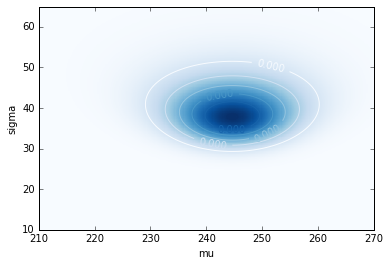

In [8]:
thinkplot.Contour(general, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

We see that our values of `mu` and `sigma` fit well within cutoff range.

Now, do the same for BRINK.

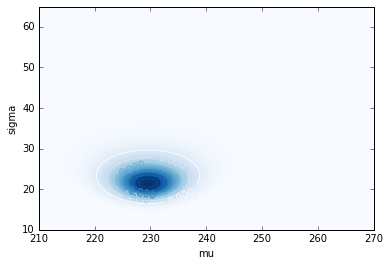

In [9]:
brink = Normal(product(mus, sigmas))
data = df[df.BRINK==1].RATIO
brink.Update(data)

thinkplot.Contour(brink, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

Finally, to get a distribution of possible ratio values, we extract the marginal distributions of `mu` from both the general contractors and BRINK.

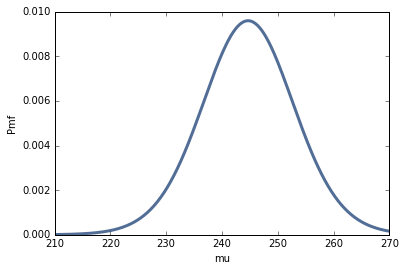

In [10]:
general_mu = general.Marginal(0)
thinkplot.Pdf(general_mu)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

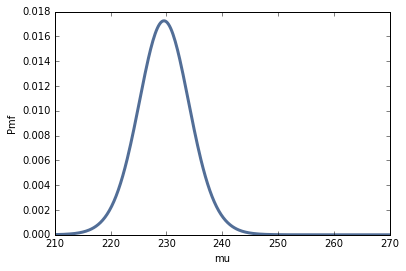

In [11]:
BRINK_mu = brink.Marginal(0)
thinkplot.Pdf(BRINK_mu)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

To see how much money was stolen, we compute the difference of the marginal distributions. This immediately gives us difference of the means of the ratios as we could have calcuated earlier.

In [12]:
pmf_diff = BRINK_mu - general_mu
pmf_diff.Mean()

-15.022318455572226

To calculate the probability that money was stolen from the city, we simply look at a plot of the cdf of pmf_diff and see the probability that the difference is less than zero.

0.93875832542936855

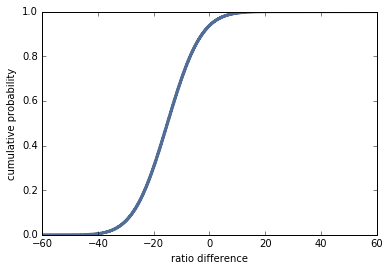

In [13]:
cdf_diff = pmf_diff.MakeCdf()
thinkplot.Cdf(cdf_diff)
thinkplot.Config(xlabel='ratio difference', ylabel='cumulative probability')
cdf_diff[0]

And we have answered the first question: the probability that money was stolen from the city is 93.9%

And lastly, we calculate how much money was stolen from the city. To do this, we first calculate how much money the city collected during (general or Brink) times. Then we can multiply this times our pmf_diff to get a probability distribution of potential stolen money.

(-3594455.9999999991, -1431125.9999999991)


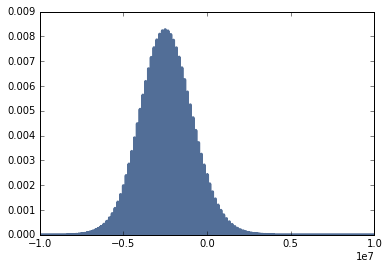

In [14]:
money_city = np.where(df['BRINK']==1, df['CITY'], 0).sum(0)
print((pmf_diff * money_city).CredibleInterval(50))
thinkplot.Pmf(pmf_diff * money_city)
thinkplot.Config(xlabel='money stolen', ylabel='probability')

Above we see a plot of stolen money in millions. We have also calculated a credible interval that tells us that there is a 50% chance that Brink stole between 1.4 to 3.6 million dollars. Interestingly, our distribution tells us that there is a probability that BRINK actually gave the city money. However, this is extremely unlikely and is an artifact of our normal distribution.

# Smoking kills, analysis of smoking in different states

http://lib.stat.cmu.edu/DASL/Datafiles/cigcancerdat.html

>The data are per capita numbers of cigarettes smoked (sold) by 43 states and the 
District of Columbia in 1960 together with death rates per thouusand population from
various forms of cancer.

If California were to lower its number of cigarette sold per capita from 28.60 to 20, how many people would die from lung cancer per 1,000 people?

To answer this question, I combine known values of California (CIG = 28.60, LUNG = 22.07) with a predictive distribution for any state at CIG = 20 to estimate the death rate from lung cancer per 1,000 people. To get this predictive distribution, I will use bayesian linear regression.

First, let's load our data into a Pandas dataframe to see what it looks like.

In [15]:
df = pd.read_csv('smokingKills.csv', skiprows=21, delimiter='\t')
df.head()

,STATE,CIG,BLAD,LUNG,KID,LEUK
0,AL,18.20,2.90,17.05,1.59,6.15
1,AZ,25.82,3.52,19.80,2.75,6.61
2,AR,18.24,2.99,15.98,2.02,6.94
3,CA,28.60,4.46,22.07,2.66,7.06
4,CT,31.10,5.11,22.83,3.35,7.20


Data seems reasonable, now let's see if a linear regression is appropriate for predicting distributions.

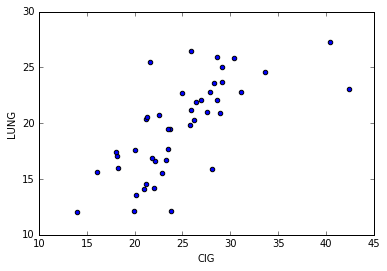

In [16]:
df.plot('CIG', 'LUNG', kind='scatter')

Data looks pretty linear. Now let's get the slope and intercept of the line of least squares. Abstract numpy's least squares function using a function of our own.

In [17]:
def leastSquares(x, y):
    """
    leastSquares takes in two arrays of values. Then it returns the slope and intercept
    of the least squares of the two.
    
    Args:
        x (numpy array): numpy array of values.
        y (numpy array): numpy array of values.
        
    Returns:
        slope, intercept (tuple): returns a tuple of floats.
    """
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y)[0]
    return slope, intercept

To use our leastSquares function, we first create x and y vectors. Where x is the cig, y is the lung. Then call leastSquares to get the slope and intercept.

In [18]:
cigs = np.array(df['CIG'])
lungs = np.array(df['LUNG'])

slope, intercept = leastSquares(cigs, lungs)
print(slope, intercept)

0.529077926985 6.47168624727


Now plot the line and the original data to see if it looks linear.

In [1]:
plt.plot(cigs, lungs, 'o', label='Original data', markersize=10)
plt.plot(cigs, slope*cigs + intercept, 'r', label='Fitted line')
plt.xlabel('Number of cigarettes sold (smoked) per capita)')
plt.ylabel('Death rate per 1,000 from lung cancer')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

Nice. Based on the plot above, we can conclude that bayesian linear regression will give us reasonable distributions for predicting future values. Now we want to create our hypotheses. Each hypothesis will consist of a intercept, slope and sigma.

In [20]:
intercepts = np.linspace(7.5, 8, 5)
slopes = np.linspace(.4, .5, 5)
sigmas = np.linspace(4.5, 5.5, 5)

Create hypos and our update data.

In [21]:
hypos = ((intercept, slope, sigma) for intercept in intercepts 
         for slope in slopes for sigma in sigmas)

data = [(cig, lung) for cig in cigs for lung in lungs]

Create least squares suite. The likelihood function will depend the data and normal distributions for each hypothesis.

In [22]:
class leastSquaresHypos(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        Likelihood calculates the probability of a particular line (hypo)
        based on data (cigs Vs lungs) of our original dataset. This is
        done with a normal pmf as each hypo also contains a sigma.
        
        Args:
            data (tuple): tuple that contains ages (float), heights (float)
            hypo (tuple): intercept (float), slope (float), sigma (float)
            
        Returns:
            P(data|hypo)
        """
        intercept, slope, sigma = hypo
        total_likelihood = 1
        for cig, measured_lung in data:
            hypothesized_lung = slope * cig + intercept
            error = measured_lung - hypothesized_lung
            total_likelihood *= EvalNormalPdf(error, mu=0, sigma=sigma)
        return total_likelihood        

Now use our hypos to create the LeastSquaresHypos suite.

In [23]:
LeastSquaresHypos = leastSquaresHypos(hypos)

Update LeastSquaresHypos with our data.

In [24]:
for item in data:
    LeastSquaresHypos.Update([item])

Next, use marginal distributions to see how our good our intercept, slope, and sigma guesses were. Note that I have already found values that work well. There aren't really guesses at this point.

For the intercepts, we choose to stay relatively close to our original intercept. This is the one value we sacrifice accuracy on. This ends up being OK because the slopes and sigmas are in good ranges. For a large value of x, slope and sigma diverge faster than intercept.

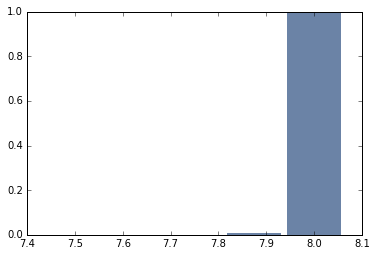

In [25]:
marginal_intercepts = LeastSquaresHypos.Marginal(0)
thinkplot.hist(marginal_intercepts)

All of the important slopes are contained in our guesses.

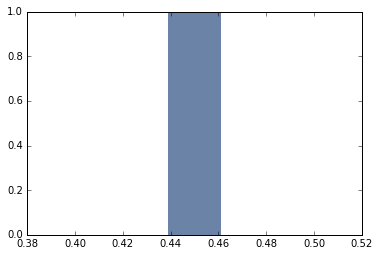

In [26]:
marginal_slopes = LeastSquaresHypos.Marginal(1)
thinkplot.hist(marginal_slopes)

All of the important sigmas are contained in our guesses.

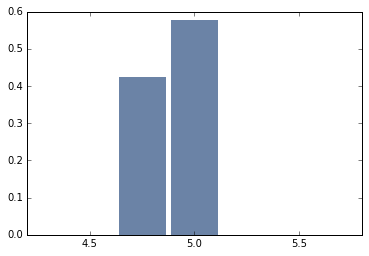

In [27]:
marginal_sigmas = LeastSquaresHypos.Marginal(2)
thinkplot.hist(marginal_sigmas)

Next, we want to sample random data from our hypotheses. We will do this by writing two functions, getY, and getRandomData. getRandomData calls getY to the random y data.

In [28]:
def getY(hypo_samples, random_x):
    """
    getY takes in random hypos and random x's and returns the coorisponding
    random height
    
    Args:
        hypo_samples
    """
    random_y = np.zeros(len(random_x))
    for i in range(len(random_x)):
        intercept = hypo_samples[i][0]
        slope = hypo_samples[i][1]
        sigma = hypo_samples[i][2]
        month = random_x[i]
        random_y[i] = np.random.normal((slope * month + intercept), sigma, 1)
    return random_y

def getRandomData(start, end, n, LeastSquaresHypos):
    """
    
    Args:
        start: (number): Starting x range of our data
        end: (number): Ending x range of our data
        n (int): Number of samples
        LeastSquaresHypos (Suite): Contains the hypos we want to sample
    """
    random_hypos = LeastSquaresHypos.Sample(n)
    random_x = np.random.uniform(start, end, n)
    random_y = getY(random_hypos, random_x)
    return random_x, random_y

In [29]:
num_samples = 10000
random_cigs, random_lungs = getRandomData(14, 43, num_samples, LeastSquaresHypos)


Now, lets see what our random data looks like plotted underneath the original data and line of least squares.

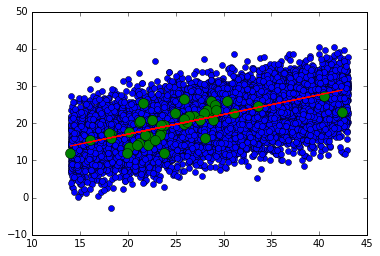

In [30]:
plt.plot(random_cigs, random_lungs, 'o', label='Random Sampling')
plt.plot(cigs, lungs, 'o', label='Original data', markersize=10)
plt.plot(cigs, slope*cigs + intercept, 'r', label='Fitted line')
plt.xlabel('Number of cigarettes sold (smoked) per capita)')
plt.ylabel('Death rate per 1,000 from lung cancer')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

From the plot above, our random data seems to make a distribution in the direction of the line. However, we are unable to see exactly what this distribution looks like as many of the random blue points overlap. We will visualize exactly what is going on with a desnity function.

To get the density (intensity), we will make a bucketData function. This takes in a range of x and y values and sees how many of the points fall into each bucket.

In [31]:
def bucketData(num_buckets, x_range, y_range, x_data, y_data):
    """
    Computes the buckets and density of items of data for graphing pixel space
    
    Args:
        num_buckets (int): Is sqrt of number of buckets
        x_range (tuple): Contains floats for x_start and x_end
        y_range (tuple): Contains floats for y_start and y_end
        x_data (sequence): Random x data. Could be something like ages
        y_data (sequence): Random y data. Could be somethign like heights
        
    Returns:
        buckets (dict): Dictionary containing density of points.
    """
    x_start, x_end = x_range
    y_start, y_end = y_range

    # create horizontal and vertical linearly spaced ranges as buckets.
    hori_range, hori_step = np.linspace(x_start, x_end, num_buckets, retstep=True)
    vert_range, vert_step = np.linspace(y_start, y_end, num_buckets, retstep=True)

    hori_step = hori_step / 2
    vert_step = vert_step / 2

    # store each bucket as a tuple in a the buckets dictionary.
    buckets = dict()
    keys = [(hori, vert) for hori in hori_range for vert in vert_range]

    # set each bucket as empty
    for key in keys:
        buckets[key] = 0

    # loop through the randomly sampled data
    for x, y in zip(x_data, y_data):
        # check each bucket and see if randomly sampled data 
        for key in buckets:
            if x > key[0] - hori_step and x < key[0] + hori_step:
                if y > key[1] - vert_step and y < key[1] + vert_step:
                    buckets[key] += 1
                    break # can only fit in a single bucket
                    
    return(buckets)

In [32]:
buckets = bucketData(num_buckets=40, x_range=(14, 43), y_range=(-10, 50), x_data=random_cigs, y_data=random_lungs)

Now create function to unpack the buckets into usable x (cigs), y (lungs), z(densities/intencities) arrays.

In [33]:
def unpackBuckets(buckets):
    """
    Unpacks buckets into three new ordered lists such that zip(xNew, yNew, zNew) would
    create x, y, z triples.
    """
    xNew = []
    yNew = []
    zNew = []
    for key in buckets:
        xNew.append(key[0])
        yNew.append(key[1])
        zNew.append(buckets[key]) 
        
    return xNew, yNew, zNew

Use said function to unpack buckets.

In [34]:
cigsNew, lungsNew, intensities = unpackBuckets(buckets)

Now, to make our lives easier, we will plot the density plot in Mathematica. But first, we need to export our data as CSV's.

In [35]:
def append_to_file(path, data):
    """
    append_to_file appends a line of data to specified file.  Then adds new line
    
    Args:
        path (string): the file path
    
    Return:
        VOID
    """
    with open(path, 'a') as file:
        file.write(data + '\n')
        
def delete_file_contents(path):
    """
    delete_file_contents deletes the contents of a file
    
    Args:
        path: (string): the file path
        
    Return:
        VOID
    """
    with open(path, 'w'):
        pass

def threeSequenceCSV(x, y, z):
    """
    Writes the x, y, z arrays to a CSV
    
    Args:
        x (sequence): x data
        y (sequence): y data
        z (sequence): z data    
    """
    file_name = 'cigsLungsIntensity.csv'
    delete_file_contents(file_name)

    for xi, yi, zi in zip(x, y, z):
        append_to_file(file_name, "{}, {}, {}".format(xi, yi, zi))
        
def twoSequenceCSV(x, y):
    """
    Writes the x, y arrays to a CSV
    
    Args:
        x (sequence): x data
        y (sequence): y data
    """
    file_name = 'cigsLungs.csv'
    delete_file_contents(file_name)
    
    for xi, yi in zip(x, y):
        append_to_file(file_name, "{}, {}".format(xi, yi))
        
def fittedLineCSV(x, slope, intercept):
    """
    Writes line data to a CSV
    
    Args:
        x (sequence): x data
        slope (float): slope of line
        intercept (float): intercept of line
    """
    file_name = 'cigsLungsFitted.csv'
    delete_file_contents(file_name)
    for xi in x:
        append_to_file(file_name, "{}, {}".format(xi, slope*xi + intercept))
        
def makeCSVData(random_x, random_y, intensities, original_x, original_y, slope, intercept):
    """
    Calls the 3 csv making functions with appropriate parameters.
    """
    threeSequenceCSV(random_x, random_y, intensities)
    twoSequenceCSV(original_x, original_y)
    fittedLineCSV(original_x, slope, intercept)

In [36]:
makeCSVData(cigsNew, lungsNew, intensities, cigs, lungs, slope, intercept)

Below we have our density plot underneath our original data / fitted line. Based on this plot, we can reason that our previous calculations seem reasonable.

x axis = Number of cigarettes sold (smoked) per capita
y axis = Death rate per 1,000 from lung cancer

<img src="cigsLungsAllPlots.png" alt="Density Plot with orignal data/fit" height="400" width="400">

Now, we want to answer our original question. If California were to lower its number of cigarette sold per capita from 28.60 to 20, how many people would die from lung cancer per 1,000 people? Now, I will do this by finding the most likeli distribution for a state at CIG = 20 and subtract the known California value (CIG = 28.60, LUNG = 22.07) from that distribution.

First make a function that makes Pmf's for a given CIG value.

In [37]:
def MakeLungsPmf(suite, x):
    """
    MakeLungsPmf takes in a suite (intercept, slope, sigma) hypos and an x value.
    It returns a mixture Pmf at that particular x value.
    
    Args:
        suite (Suite): Suite object of (intercept, slope, sigma) hypos
        x (number): The value used to calculate the center of the new distribution
    """
    metapmf = Pmf()
    
    counter=0

    for (intercept, slope, sigma), prob in suite.Items():
        mu = slope * x + intercept
        pmf = MakeNormalPmf(mu, sigma, num_sigmas=4, n=301)
        metapmf.Set(pmf, prob)
        counter+=1
        if counter % 100 == 0:
            print(counter)

    mix = MakeMixture(metapmf)
    return mix

Use our function to make a LUNGS distribution for a state at CIG = 20.

In [38]:
cigs20 = MakeLungsPmf(LeastSquaresHypos, 20)

100


Now make our California lives saved prediction by subtracting 22.07 from the previous distribution

In [39]:
cali20_lives_predict = cigs20.AddConstant(-22.07)

17.066708705383373

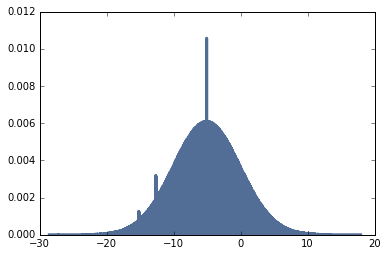

In [40]:
thinkplot.Pmf(cali20_lives_predict)
22.07 + cali20_lives_predict.Mean()

Based on the above distribution, we that California will most likely reduce its death by lung cancer per 1,000 people from 22.07 to 17.06. We can also use this distribution to see what values are credible.

In [41]:
cali20_lives_predict.CredibleInterval(50)

(-8.3633333333333315, -1.7366666666666681)

Now we can see that there is a 50% chance that Calfornia will reduce it's death by lung cancer per 1,000 people by 1.74 to 8.36 deaths per 1000 people.